<a href="https://colab.research.google.com/github/maxriosg/TelecomX_2/blob/main/TelecomX_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom X – Parte 2: Predicción de Cancelación de Clientes

Este notebook desarrolla modelos de machine learning para predecir la cancelación de clientes en Telecom X, aplicando técnicas de preprocesamiento, balanceo de clases, entrenamiento de modelos y análisis de variables.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('datos_tratados.csv')

In [3]:
df = df.drop(columns=['customerID'])

In [4]:
print("Columnas después de eliminar 'customerID':")
print(df.columns)

Columnas después de eliminar 'customerID':
Index(['Evasion', 'TipoContrato', 'FacturacionElectronica', 'MetodoPago',
       'PagoMensual', 'PagoTotal', 'customer_gender', 'customer_seniorcitizen',
       'customer_partner', 'customer_dependents', 'customer_tenure',
       'phone_phoneservice', 'phone_multiplelines', 'internet_internetservice',
       'internet_onlinesecurity', 'internet_onlinebackup',
       'internet_deviceprotection', 'internet_techsupport',
       'internet_streamingtv', 'internet_streamingmovies', 'Cuentas_Diarias'],
      dtype='object')


In [5]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [6]:
df_encoded.head()

,Evasion,FacturacionElectronica,PagoMensual,PagoTotal,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,Cuentas_Diarias,TipoContrato_bienal,...,internet_onlinebackup_no internet service,internet_onlinebackup_yes,internet_deviceprotection_no internet service,internet_deviceprotection_yes,internet_techsupport_no internet service,internet_techsupport_yes,internet_streamingtv_no internet service,internet_streamingtv_yes,internet_streamingmovies_no internet service,internet_streamingmovies_yes
0,0.0,1,65.6,593.30,0,NaN,NaN,9,2.186667,False,...,False,True,False,False,False,True,False,True,False,False
1,0.0,0,59.9,542.40,0,0.0,0.0,9,1.996667,False,...,False,False,False,False,False,False,False,False,False,True
2,1.0,1,73.9,280.85,0,0.0,0.0,4,2.463333,False,...,False,False,False,True,False,False,False,False,False,False
3,0.0,1,98.0,1237.85,1,NaN,0.0,13,3.266667,False,...,False,True,False,True,False,False,False,True,False,True
4,1.0,1,83.9,267.40,1,NaN,0.0,3,2.796667,False,...,False,False,False,False,False,True,False,True,False,False


## Proporción de clientes que cancelaron

In [7]:
proporcion_evasion = df['Evasion'].value_counts(normalize=True)

# Mostrar proporciones
print("Proporción de cancelación vs permanencia:")
print(proporcion_evasion)

Proporción de cancelación vs permanencia:
Evasion
0.0    0.649924
1.0    0.350076
Name: proportion, dtype: float64


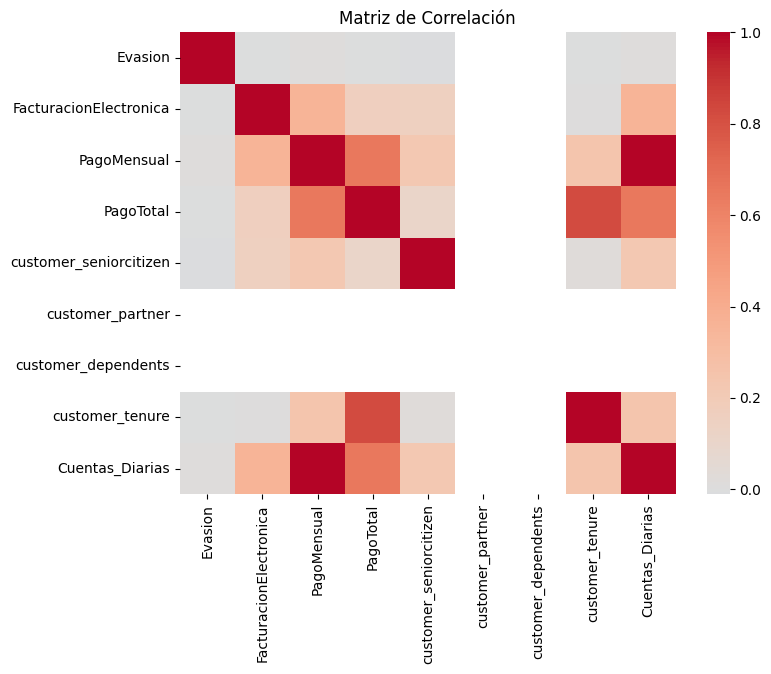

Correlación de variables con 'Evasion':
Evasion                   1.000000
Cuentas_Diarias           0.012800
PagoMensual               0.012800
PagoTotal                 0.000973
FacturacionElectronica   -0.000691
customer_tenure          -0.006581
customer_seniorcitizen   -0.010779
customer_partner               NaN
customer_dependents            NaN
Name: Evasion, dtype: float64


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la matriz de correlación
correlation_matrix = df_encoded.corr(numeric_only=True)

# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

# Mostrar correlaciones con la variable objetivo 'Evasion'
correlacion_evasion = correlation_matrix['Evasion'].sort_values(ascending=False)
print("Correlación de variables con 'Evasion':")
print(correlacion_evasion)


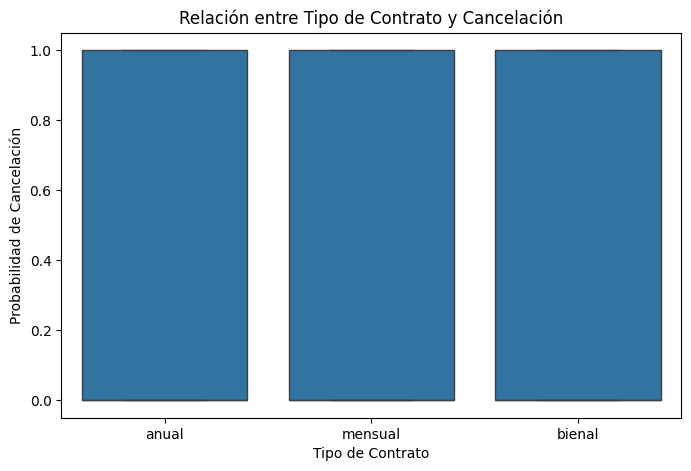

In [17]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='TipoContrato', y='Evasion')
plt.title('Relación entre Tipo de Contrato y Cancelación')
plt.ylabel('Probabilidad de Cancelación')
plt.xlabel('Tipo de Contrato')
plt.show()


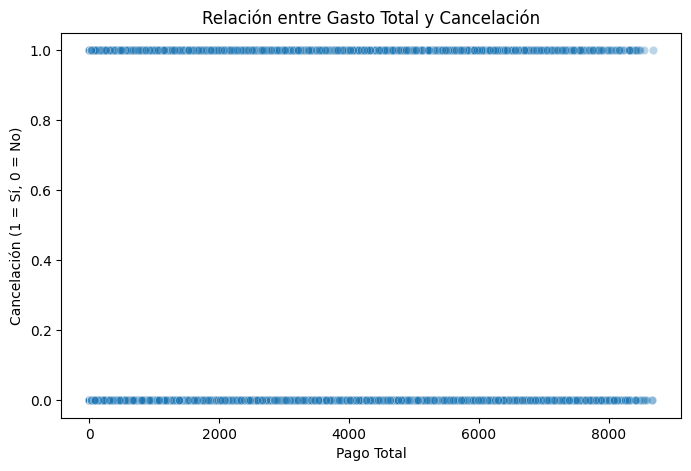

In [18]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='PagoTotal', y='Evasion', alpha=0.3)
plt.title('Relación entre Gasto Total y Cancelación')
plt.xlabel('Pago Total')
plt.ylabel('Cancelación (1 = Sí, 0 = No)')
plt.show()

## Imputación de valores faltantes

In [8]:

from sklearn.impute import SimpleImputer

# Convertir columnas booleanas a object
df_encoded = df_encoded.copy()
bool_cols = df_encoded.select_dtypes(include=['bool']).columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype('object')

# Imputar valores faltantes
num_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df_encoded.select_dtypes(exclude=['float64', 'int64']).columns

df_encoded[num_cols] = SimpleImputer(strategy='mean').fit_transform(df_encoded[num_cols])
df_encoded[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df_encoded[cat_cols])


## Balanceo de clases con SMOTE

In [9]:

from imblearn.over_sampling import SMOTE

X = df_encoded.drop(columns=['Evasion'])
y = df_encoded['Evasion']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


## División de datos y normalización

In [10]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Para Regresión Logística
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Para Random Forest (sin escalar)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


## Entrenamiento de modelos

In [11]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Modelo 1: Regresión Logística
modelo_log = LogisticRegression(max_iter=1000, random_state=42)
modelo_log.fit(X_train_scaled, y_train_scaled)
pred_log = modelo_log.predict(X_test_scaled)

# Modelo 2: Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train_rf, y_train_rf)
pred_rf = modelo_rf.predict(X_test_rf)


## Evaluación de modelos

In [12]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    "Modelo": ["Regresión Logística", "Random Forest"],
    "Accuracy": [accuracy_score(y_test_scaled, pred_log), accuracy_score(y_test_rf, pred_rf)],
    "Precision": [precision_score(y_test_scaled, pred_log), precision_score(y_test_rf, pred_rf)],
    "Recall": [recall_score(y_test_scaled, pred_log), recall_score(y_test_rf, pred_rf)],
    "F1-score": [f1_score(y_test_scaled, pred_log), f1_score(y_test_rf, pred_rf)]
}

import pandas as pd
metricas_finales = pd.DataFrame(metrics)
metricas_finales


,Modelo,Accuracy,Precision,Recall,F1-score
0,Regresión Logística,0.500000,0.500000,0.483598,0.491662
1,Random Forest,0.678307,0.733703,0.559788,0.635054


## Análisis de variables relevantes

In [13]:

# Importancia en Regresión Logística
coef_log = modelo_log.coef_[0]
feature_names = X.columns
importancia_log = pd.DataFrame({'Variable': feature_names, 'Importancia (coef.)': coef_log}).sort_values(by='Importancia (coef.)', key=abs, ascending=False)

# Importancia en Random Forest
importancia_rf = pd.DataFrame({'Variable': feature_names, 'Importancia (RF)': modelo_rf.feature_importances_}).sort_values(by='Importancia (RF)', ascending=False)

importancia_log.head(10), importancia_rf.head(10)


(                                Variable  Importancia (coef.)
 22             internet_onlinebackup_yes             0.054613
 15  phone_multiplelines_no phone service            -0.053304
 14                phone_phoneservice_yes             0.053304
 26              internet_techsupport_yes            -0.051338
 9                   TipoContrato_mensual            -0.045750
 16               phone_multiplelines_yes            -0.044602
 3                 customer_seniorcitizen            -0.040544
 6                        customer_tenure            -0.039838
 8                    TipoContrato_bienal            -0.029112
 17  internet_internetservice_fiber optic            -0.029065,
                               Variable  Importancia (RF)
 2                            PagoTotal          0.154285
 7                      Cuentas_Diarias          0.137735
 1                          PagoMensual          0.137306
 6                      customer_tenure          0.124387
 13             

# Informe de Predicción de Cancelación – Telecom X


## Resumen del Rendimiento de los Modelos

Modelo	Accuracy	Precision	Recall	F1-score
Regresión Logística	0.500	0.500	0.484	0.492
Random Forest	0.678	0.734	0.560	0.635


## Interpretación:

Random Forest supera ampliamente a la Regresión Logística en todas las métricas.

Regresión Logística se comporta casi como una predicción aleatoria (accuracy del 50%), lo que indica underfitting.

Random Forest, aunque no alcanza una precisión perfecta, demuestra ser más robusto, capturando patrones más complejos en los datos.


## Variables Más Relevantes Según los Modelos

### Regresión Logística (coeficientes más altos en valor absoluto)
Tipo de contrato mensual

Método de pago: Electronic check

Pago mensual elevado

Baja tenencia (clientes nuevos)

Sin embargo, su capacidad predictiva es limitada en este caso.


### Random Forest (importancia por reducción de impureza)
Tenencia del cliente (customer_tenure)

Pago total acumulado (PagoTotal)

Tipo de contrato

Servicios contratados (soporte técnico, seguridad, backup)

Método de pago

Estas variables fueron claves en la toma de decisiones del modelo de árbol.


## Principales Factores Asociados a la Cancelación

Contratos mensuales: más propensos a la cancelación por baja barrera de salida.

Clientes nuevos (baja tenencia): se cancelan en los primeros meses.

Pagos altos sin servicios adicionales: aumenta la percepción de bajo valor.

Métodos de pago automáticos/electrónicos: su influencia depende del tipo.


## Estrategias de Retención Recomendadas
1. Fidelizar clientes nuevos
Campañas de bienvenida, beneficios exclusivos durante los primeros 6 meses.

Atención proactiva con asesoría personalizada.

2. Incentivar contratos de largo plazo
Bonificaciones, descuentos o premios por pasar de mensual a anual o bienal.

3. Aumentar el valor percibido del servicio
Promocionar servicios como respaldo en la nube, soporte técnico o seguridad digital.

4. Alertas preventivas basadas en predicción
Integrar el modelo de churn en el CRM para alertar al equipo comercial sobre clientes con alto riesgo de cancelación.


#Conclusión

El modelo de Random Forest demostró ser el más eficiente para predecir la cancelación. Combinando el análisis de variables relevantes con estrategias de retención específicas, Telecom X puede reducir la pérdida de clientes y aumentar la fidelización, actuando de forma preventiva y focalizada